In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
import os
import matplotlib.pyplot as plt
import matplotlib
import matplotlib as mpl
import pandas as pd
import numpy as np
import hyperopt
import time
import sklearn.metrics as mt
import pickle

from xgboost import Booster
from xgboost import XGBClassifier
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from itertools import chain

C:\Users\marsl\anaconda3\envs\ML\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
#################################################################################################
###### The function load_window_dataset() that takes in input window data file, and 
###### label to be assigned and returns numpy arrays with features and labels
#################################################################################################

def load_window_dataset(X, y, filename, label):
#Inputs: - X: current matrix of datapoints where we want to APPEND the datapoints retrieved from filename (only features)
#        - y: current matrix of datapoints where we want to APPEND the datapoints retrieved from filename (only labels)
#        - filename: full name (with path) of the file to be read (it must be a window dataset file created above)
#        - label: integer, label to be assigned to the datapoints retrieved from filename; it may differ from labels already included in current y
#Outputs: - X: updated X (including features for the new data points retrieved from filename)
#         - y: updated y (including labels for the new data points)
#This function to X and y in input the new datapoints retrieved from filename and return updated X and y
#The function handle the case when X and y are empty (initialized as None)

    data = pd.read_csv(filename)
    
    if X is None:
        X = data.to_numpy()
        # full() function puts in all X.shape[0] elements the value "label"
        y = np.full(X.shape[0], label)
    else:
        X_temp = data.to_numpy()
        y_temp = np.full(X_temp.shape[0], label)
        X = np.append(X, X_temp, axis = 0) #F: axis=0-->stack X and X_temp vertically (increase no of rows)
        y = np.append(y, y_temp)

    return X, y

In [4]:
def train_classifier_XGB(X_train, y_train): 
    xgb = XGBClassifier(use_label_encoder=False, eta = 0.7, max_depth= 7, subsample = 1, verbosity = 0)

    # Execute the traning 3 times to be sure that the training time is correct
    ttimes = []
    for i in range(0, 3):
        t0 = time.time()
        xgb.fit(X_train, y_train)
        t1 = time.time()
        ex_time = t1 - t0
        ttimes.append(ex_time)
        print(ex_time)

    return xgb, ttimes

In [5]:
def train_classifier_DNN(X_train, y_train): 
    size = (50,) * 2
    dnn = MLPClassifier(hidden_layer_sizes=size, activation='tanh',
                        solver='adam', learning_rate='invscaling', max_iter=1000)

    # Execute the traning 3 times to be sure that the training time is correct
    ttimes = []
    for i in range(0, 3):
        t0 = time.time()
        dnn.fit(X_train, y_train)
        t1 = time.time()
        ex_time = t1 - t0
        ttimes.append(ex_time)
        print(ex_time)

    return dnn, ttimes

In [6]:
def train_classifier_KNN(X_train, y_train): 
    knn = KNeighborsClassifier(leaf_size=43, p=1, n_neighbors=14)

    # Execute the traning 3 times to be sure that the training time is correct
    ttimes = []
    for i in range(0, 3):
        t0 = time.time()
        knn.fit(X_train, y_train)
        t1 = time.time()
        ex_time = t1 - t0
        ttimes.append(ex_time)
        print(ex_time)

    return knn, ttimes

In [7]:
########################################################################################################
###### The function performance_eval() takes in input ground truth and predicted labels, 
###### prints results in a result file passed in input, and returns global metrics
########################################################################################################

def performance_eval(y_true, y_pred, lab, l_names):

    #Compute metrics and print/write them
    accuracy = mt.accuracy_score(y_true, y_pred)
    precision = mt.precision_score(y_true, y_pred, labels=lab, average=None) #F: average=None gives per-class results
    global_precision = mt.precision_score(y_true, y_pred, labels=lab, average='weighted') 
    recall = mt.recall_score(y_true, y_pred, labels=lab, average=None)
    global_recall = mt.recall_score(y_true, y_pred, labels=lab, average='weighted') 
    f1score = mt.f1_score(y_true, y_pred, labels=lab, average=None)
    global_f1score = mt.f1_score(y_true, y_pred, labels=lab, average='weighted')

    return accuracy, global_precision, global_recall, global_f1score 

In [8]:
windowrange=[3, 5, 10, 30, 75, 150, 300, 750, 1200, 1800, 3600]
spacingrange=[3, 5, 10, 30, 75, 150, 300, 750, 1200, 1800, 3600]

A_XGB = np.zeros([len(spacingrange),len(windowrange)])
GP_XGB = np.zeros([len(spacingrange),len(windowrange)])
GR_XGB = np.zeros([len(spacingrange),len(windowrange)])
GF1_XGB = np.zeros([len(spacingrange),len(windowrange)])

A_DNN = np.zeros([len(spacingrange),len(windowrange)])
GP_DNN = np.zeros([len(spacingrange),len(windowrange)])
GR_DNN = np.zeros([len(spacingrange),len(windowrange)])
GF1_DNN = np.zeros([len(spacingrange),len(windowrange)])

A_KNN = np.zeros([len(spacingrange),len(windowrange)])
GP_KNN = np.zeros([len(spacingrange),len(windowrange)])
GR_KNN = np.zeros([len(spacingrange),len(windowrange)])
GF1_KNN = np.zeros([len(spacingrange),len(windowrange)])

def training_loop(windowrange, spacingrange):
    global A_XGB, GP_XGB, GR_XGB, GF1_XGB
    global A_DNN, GP_DNN, GR_DNN, GF1_DNN
    global A_KNN, GP_KNN, GR_KNN, GF1_KNN
    
    xgb_all_ttimes = []
    dnn_all_ttimes = []
    knn_all_ttimes = []
    
    lbl = [0, 1]
    label_names=['Attenuation', 'Filtering']

    for i, spacing in enumerate(spacingrange): #enumerate(range(minsp,maxsp+1,stepsp)):
        for j, length in enumerate(windowrange): #enumerate(range(minlength,maxlength+1,steplength)):
            print('********************************')
            print('Iteration for spacing={} and window length={}'.format(spacing,length))

            ####### 1) Load dataset #######
            print('1) Loading dataset into (XX,yy)...')

            XX = None
            yy = None
            folderpath='../Features_raw'

            for filename in os.listdir(folderpath):
                if filename.endswith('_sp' + str(spacing) + '_w' + str(length) + '.dat'):
                    label = 0
                    if int(filename[9]) > 5:
                        label = 1
                    fullname = folderpath + '/' + filename
                    XX, yy = load_window_dataset(XX, yy, fullname, label)

            scaler = StandardScaler()
            XX = scaler.fit_transform(XX)

            X_train, X_test, y_train, y_test = train_test_split(XX, yy, stratify=yy, test_size=0.3, random_state=42)
            print('Training XGB...')
            xgb, xgb_ttimes = train_classifier_XGB(X_train, y_train)

            print('Training DNN...')
            dnn, dnn_ttimes = train_classifier_DNN(X_train, y_train)

            print('Training KNN...')
            knn, knn_ttimes = train_classifier_KNN(X_train, y_train)

            xgb_all_ttimes.append(xgb_ttimes)
            dnn_all_ttimes.append(dnn_ttimes)
            knn_all_ttimes.append(knn_ttimes)

            y_pred_XGB = xgb.predict(X_test)
            y_pred_DNN = dnn.predict(X_test)
            y_pred_KNN = knn.predict(X_test)

            A_XGB[i,j], GP_XGB[i,j], GR_XGB[i,j], GF1_XGB[i,j] = performance_eval(y_test, y_pred_XGB, lbl, label_names)
            A_DNN[i,j], GP_DNN[i,j], GR_DNN[i,j], GF1_DNN[i,j] = performance_eval(y_test, y_pred_DNN, lbl, label_names)
            A_KNN[i,j], GP_KNN[i,j], GR_KNN[i,j], GF1_KNN[i,j] = performance_eval(y_test, y_pred_KNN, lbl, label_names)

    return xgb_all_ttimes, dnn_all_ttimes, knn_all_ttimes

In [9]:
fig_folder = '1_6_Figures/Presentation'
if not os.path.exists(fig_folder):
    os.makedirs(fig_folder)

xgb_all_ttimes, dnn_all_ttimes, knn_all_ttimes = training_loop(windowrange, spacingrange)

********************************
Iteration for spacing=3 and window length=3
1) Loading dataset into (XX,yy)...
Training XGB...
2.334350109100342
2.6348018646240234
2.6982624530792236
Training DNN...
25.682785987854004
35.96990990638733
73.1892900466919
Training KNN...
0.23802495002746582
0.190687894821167
0.2145237922668457
********************************
Iteration for spacing=3 and window length=5
1) Loading dataset into (XX,yy)...
Training XGB...
3.3556792736053467
3.956594944000244
3.4592247009277344
Training DNN...
47.94815182685852
59.68630814552307
90.68792510032654
Training KNN...
0.25011420249938965
0.2809298038482666
0.2660503387451172
********************************
Iteration for spacing=3 and window length=10
1) Loading dataset into (XX,yy)...
Training XGB...
3.0598556995391846
3.02933669090271
3.1137945652008057
Training DNN...
47.92580270767212
65.00834655761719
55.542261362075806
Training KNN...
0.32912206649780273
0.31823277473449707
0.31797170639038086
**************

34.677850008010864
Training KNN...
0.05707836151123047
0.05277228355407715
0.050777435302734375
********************************
Iteration for spacing=10 and window length=30
1) Loading dataset into (XX,yy)...
Training XGB...
0.5343906879425049
0.52142333984375
0.5142059326171875
Training DNN...
37.45425891876221
40.12104082107544
14.069149732589722
Training KNN...
0.05699753761291504
0.05877852439880371
0.057000160217285156
********************************
Iteration for spacing=10 and window length=75
1) Loading dataset into (XX,yy)...
Training XGB...
0.7806215286254883
0.890143871307373
0.42332911491394043
Training DNN...
22.762272834777832
16.368717670440674
12.885509490966797
Training KNN...
0.0632169246673584
0.04705190658569336
0.06271243095397949
********************************
Iteration for spacing=10 and window length=150
1) Loading dataset into (XX,yy)...
Training XGB...
0.3578915596008301
0.354733943939209
0.359163761138916
Training DNN...
8.245455980300903
10.5416998863220

0.10923099517822266
0.09414935111999512
Training DNN...
2.423675537109375
1.8725504875183105
2.3392930030822754
Training KNN...
0.014008045196533203
0.0
0.0
********************************
Iteration for spacing=75 and window length=300
1) Loading dataset into (XX,yy)...
Training XGB...
0.09743833541870117
0.10686254501342773
0.12541460990905762
Training DNN...
1.3450171947479248
1.559706687927246
1.2942357063293457
Training KNN...
0.0
0.01562356948852539
0.0
********************************
Iteration for spacing=75 and window length=750
1) Loading dataset into (XX,yy)...
Training XGB...
0.09226846694946289
0.09377098083496094
0.10463070869445801
Training DNN...
1.2096209526062012
1.4903714656829834
1.3949501514434814
Training KNN...
0.0031976699829101562
0.0
0.013507843017578125
********************************
Iteration for spacing=75 and window length=1200
1) Loading dataset into (XX,yy)...
Training XGB...
0.07783269882202148
0.08695507049560547
0.07502365112304688
Training DNN...
1

Training XGB...
0.06231975555419922
0.06409788131713867
0.06157422065734863
Training DNN...
0.5040514469146729
0.5957455635070801
0.7195510864257812
Training KNN...
0.018401622772216797
0.0022029876708984375
0.0016107559204101562
********************************
Iteration for spacing=750 and window length=3
1) Loading dataset into (XX,yy)...
Training XGB...
0.17664599418640137
0.16832947731018066
0.17201876640319824
Training DNN...
2.5063467025756836
1.6880888938903809
1.3620939254760742
Training KNN...
0.0021452903747558594
0.0016014575958251953
0.0012252330780029297
********************************
Iteration for spacing=750 and window length=5
1) Loading dataset into (XX,yy)...
Training XGB...
0.06039571762084961
0.06264495849609375
0.07155704498291016
Training DNN...
1.2551660537719727
1.3692686557769775
1.1987910270690918
Training KNN...
0.0
0.015636444091796875
0.0
********************************
Iteration for spacing=750 and window length=10
1) Loading dataset into (XX,yy)...
Tr

0.3444688320159912
0.31290364265441895
0.3304574489593506
Training KNN...
0.0
0.0
0.0
********************************
Iteration for spacing=1800 and window length=75
1) Loading dataset into (XX,yy)...
Training XGB...
0.04845929145812988
0.06136345863342285
0.048944711685180664
Training DNN...
0.3214254379272461
0.3474111557006836
0.3224027156829834
Training KNN...
0.0021436214447021484
0.0015747547149658203
0.001603841781616211
********************************
Iteration for spacing=1800 and window length=150
1) Loading dataset into (XX,yy)...
Training XGB...
0.06315922737121582
0.05758166313171387
0.052093505859375
Training DNN...
0.2983863353729248
0.31553030014038086
0.2959561347961426
Training KNN...
0.0
0.0
0.0
********************************
Iteration for spacing=1800 and window length=300
1) Loading dataset into (XX,yy)...
Training XGB...
0.05631375312805176
0.053620338439941406
0.057080984115600586
Training DNN...
0.2593355178833008
0.29758262634277344
0.2360832691192627
Train

In [10]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    ax.set_xlabel('Window')
    ax.set_ylabel('Spacing')
    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


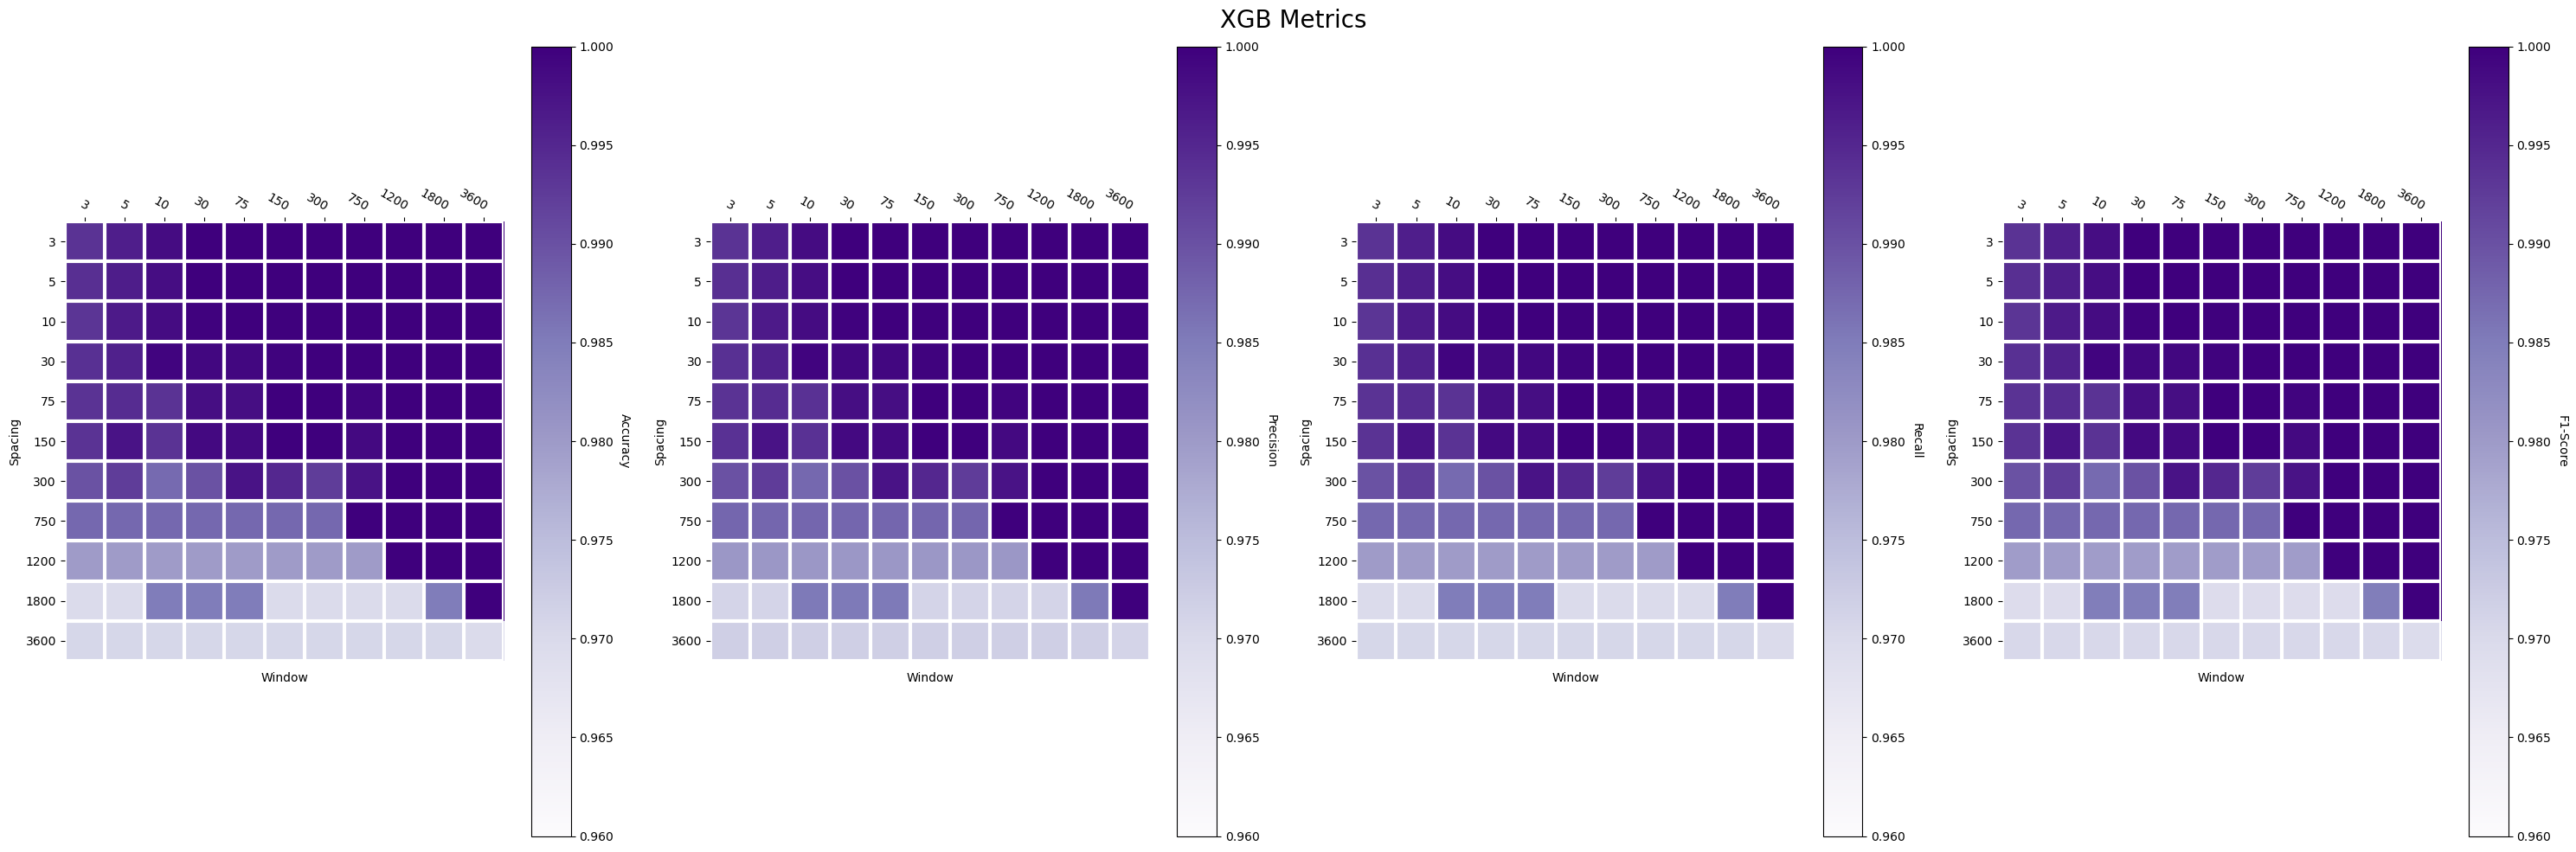

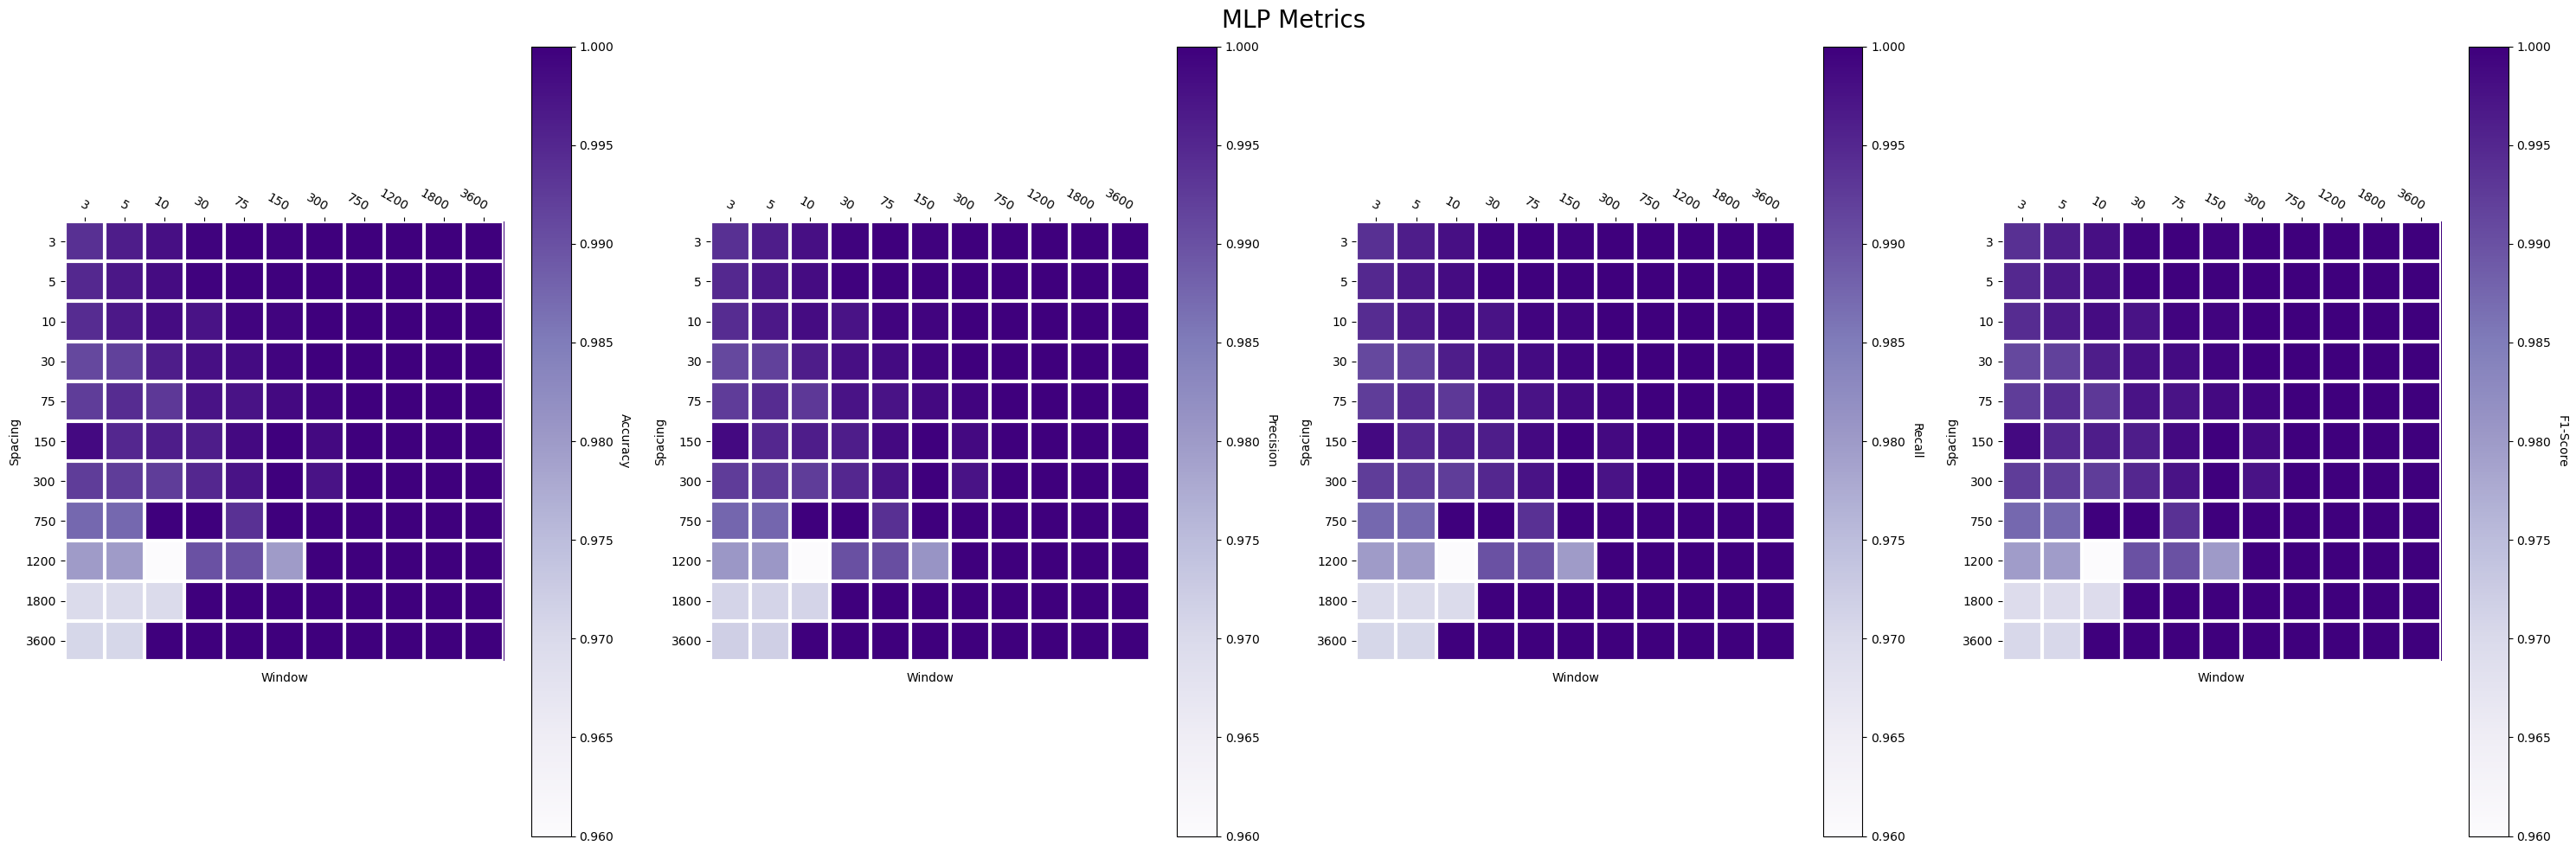

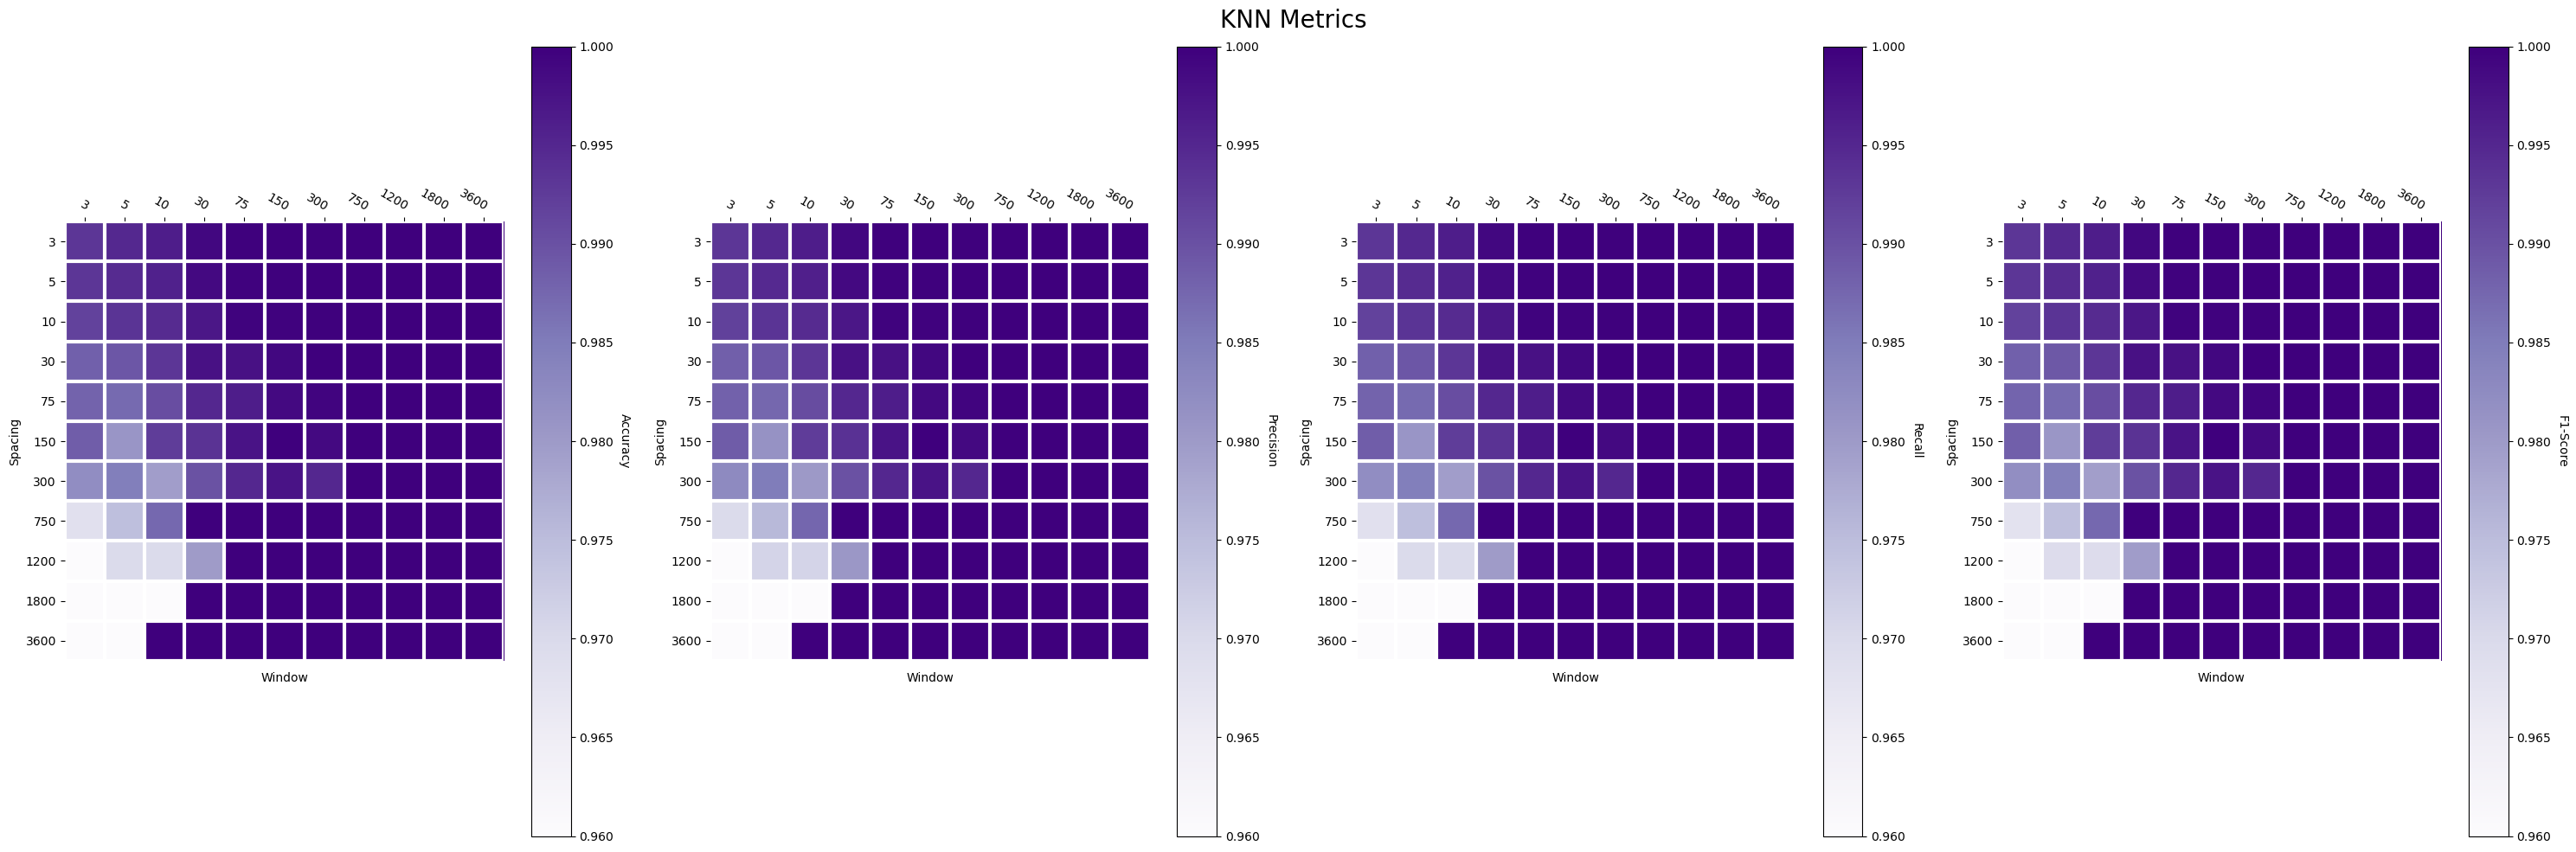

In [12]:
str_window_range = [str(x) for x in windowrange]
str_spacing_range = [str(x) for x in spacingrange]

alg_names = ['XGB', 'MLP', 'KNN']

A_mat = [A_XGB, A_DNN, A_KNN]
GP_mat = [GP_XGB, GP_DNN, GP_KNN]
GR_mat = [GR_XGB, GR_DNN, GR_KNN]
GF1_mat = [GF1_XGB, GF1_DNN, GF1_KNN]

for i in range(0, 3):
    fig, ((ax, ax2, ax3, ax4)) = plt.subplots(1, 4, figsize=(30,10))

    im, _ = heatmap(A_mat[i], str_spacing_range, str_window_range, ax=ax,
                    cmap="Purples", cbarlabel="Accuracy", vmin=0.96, vmax=1)

    im, _ = heatmap(GP_mat[i], str_spacing_range, str_window_range, ax=ax2,
                    cmap="Purples", cbarlabel="Precision", vmin=0.96, vmax=1)

    im, _ = heatmap(GR_mat[i], str_spacing_range, str_window_range, ax=ax3,
                    cmap="Purples", cbarlabel="Recall", vmin=0.96, vmax=1)

    im, _ = heatmap(GF1_mat[i], str_spacing_range, str_window_range, ax=ax4,
                    cmap="Purples", cbarlabel="F1-Score", vmin=0.96, vmax=1)

    title = alg_names[i] + " Metrics"
    fig.suptitle(title, fontsize=20)
    fig.savefig(fig_folder+'/'+title.replace(" ", "_")+'.png')
    plt.tight_layout()
    plt.show()

In [ ]:
all_ttimes = [xgb_all_ttimes, dnn_all_ttimes, knn_all_ttimes]

xgb_all_ttimes_mean = []
dnn_all_ttimes_mean = []
knn_all_ttimes_mean = []
    
all_ttimes_mean = [xgb_all_ttimes_mean, dnn_all_ttimes_mean, knn_all_ttimes_mean]

for ttimes in xgb_all_ttimes:
    xgb_all_ttimes_mean.append(sum(ttimes)/len(ttimes))

for ttimes in dnn_all_ttimes:
    dnn_all_ttimes_mean.append(sum(ttimes)/len(ttimes))
    
for ttimes in knn_all_ttimes:
    knn_all_ttimes_mean.append(sum(ttimes)/len(ttimes))

In [ ]:
all_times_mat = []

for alg_all_ttimes in all_ttimes_mean:
    mat = []
    while alg_all_ttimes != []:
        mat.append(alg_all_ttimes[:len(windowrange)])
        alg_all_ttimes = alg_all_ttimes[len(windowrange):]
    mat = np.array(mat)
    all_times_mat.append(mat)

for i in range(0, 3):
    fig, ax = plt.subplots(figsize=(15,8))
    title = alg_names[i] + " Traning Time"
    im, cbar = heatmap(all_times_mat[i], str_spacing_range, str_window_range, ax=ax,
                       cmap="OrRd", cbarlabel="Traning Time")
    
    plt.title(title, fontsize=14)
    fig.tight_layout()
    fig.savefig(fig_folder+'/'+title.replace(" ", "_")+'.png')                       
    plt.show()
